In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
rcParams['figure.figsize'] = 12, 4

In [2]:
data = pd.read_csv('data_v3.1.csv')

In [3]:
data.head(5)

,Unnamed: 0,profile_id,company,size,industry,hq_country,level,tenure,tot_tenure,avg_tenure,target,salary,country,continent,int_count,skill_count,qual_type,degree,have_web,title
0,0,TX2lkDILT7ipMZ_6jt6X,panti asuhan kerahiman hawai papua,Unknown,NaN,NaN,NaN,22646,0.0,0.0,loyal,Unknown,indonesia,asia,0.0,0.0,none,NaN,N,none
1,1,-drFXizgQaSS6QApPYZQ,autoprofit marketing pte,Unknown,NaN,NaN,NaN,21823,0.0,0.0,loyal,"55,000-70,000",singapore,asia,0.0,8.0,none,NaN,N,none
2,2,DY0Ed5iVQcy15UPDS1i7,cherrybelle,Unknown,NaN,NaN,NaN,2192,0.0,0.0,loyal,Unknown,indonesia,asia,0.0,0.0,none,NaN,N,none
3,3,HelFHtkjT0C-ab89XR7m,"second to none, inc.",1001-5000,market research,united states,NaN,6210,0.0,0.0,loyal,Unknown,indonesia,asia,0.0,6.0,none,NaN,Y,none
4,4,17tAIFLSQCWi7SNRapja,microsoft,10001+,computer software,united states,c,22281,0.0,0.0,loyal,Unknown,singapore,asia,0.0,3.0,none,NaN,Y,c


In [4]:
data.describe()

,Unnamed: 0,tenure,tot_tenure,avg_tenure,int_count,skill_count
count,529132.000000,529132.000000,529132.000000,529132.000000,529132.000000,529132.000000
mean,264565.500000,1113.800314,2038.325465,759.536388,1.815078,20.185698
std,152747.395655,1304.123331,2659.142882,973.848076,7.288523,18.771527
min,0.000000,28.000000,-10957.000000,-3652.333333,0.000000,0.000000
25%,132282.750000,336.000000,0.000000,0.000000,0.000000,10.000000
50%,264565.500000,730.000000,1156.000000,519.000000,0.000000,17.000000
75%,396848.250000,1402.000000,2950.000000,1061.781250,1.000000,25.000000
max,529131.000000,22646.000000,80870.000000,22645.000000,227.000000,647.000000


In [5]:
# Tenure is our target, 'level' and 'degree' are useless because info is in 'title'
# 'hq_country' and 'industry' need a dict to be used, drop for now
# Also 'country' and 'continent' in the data only include very few, might be biased. We also drop them
data = data.drop(['tenure','Unnamed: 0','profile_id','company','industry',
                  'hq_country','level','degree','country','continent'], axis = 1)

#Get rid of extrem values(tenure > 50 years and have too many industries and skills)
data = data[data['tot_tenure'] < 18250]
data = data[data['avg_tenure'] < 18250]
data = data[data['int_count'] < 20]
data = data[data['skill_count'] < 50]


#Replace some duplicate category names
data['salary'] = data['salary'].replace({'Unknown':'PNT'})
data['title'] = data['title'].replace({'none':'no_title'})
data['target'] = data['target'].replace({'loyal':0,'disloyal':1})


#Get dummies for catgorical features
cat_col = ['size', 'salary', 'qual_type', 'have_web', 'title']

for feature in cat_col:
    data = data.join(pd.get_dummies(data[feature]))
    data = data.drop(feature, axis = 1)


In [6]:
data

,tot_tenure,avg_tenure,target,int_count,skill_count,1-10,10001+,1001-5000,11-50,201-500,...,none,N,Y,c,dir,mgr,no_title,owner,pres,vp
0,0.0,0.000000,0,0.0,0.0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
1,0.0,0.000000,0,0.0,8.0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
2,0.0,0.000000,0,0.0,0.0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
3,0.0,0.000000,0,0.0,6.0,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
4,0.0,0.000000,0,0.0,3.0,0,1,0,0,0,...,1,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529127,3016.0,430.857143,1,10.0,27.0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
529128,2496.0,832.000000,1,0.0,27.0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
529129,1312.0,218.666667,1,14.0,30.0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
529130,1767.0,294.500000,1,0.0,19.0,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0


In [7]:
train, test = train_test_split(data, test_size=0.2)

In [8]:
target = 'target'

In [9]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score : %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                      
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    cm = confusion_matrix(dtrain[target].values, dtrain_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=alg.classes_)
    disp.plot()
    plt.show()

In [10]:
#Choose all predictors except target column
predictors = [x for x in train.columns if x not in [target]]


Model Report
Accuracy : 0.7287
AUC Score : 0.712704


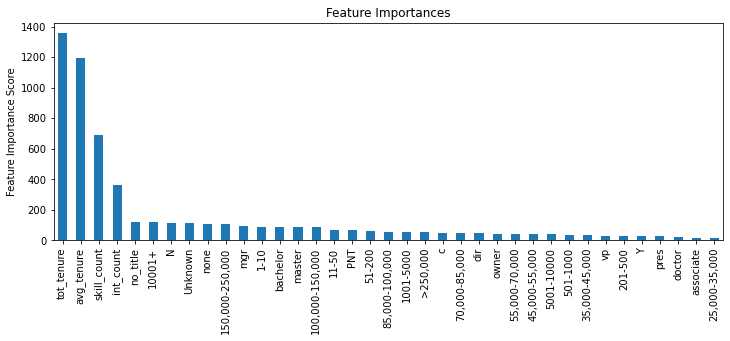

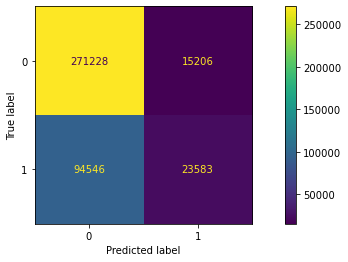

In [11]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder=False)

modelfit(xgb1, train, predictors)

In [12]:
#tune max_depth & min_child_weight
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 eval_metric='auc', nthread=4, scale_pos_weight=1, seed=27, use_label_encoder=False), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 41.90687814,  41.12707615,  41.08014379,  69.84875379,
          72.35056581,  71.65345149, 103.80563593, 103.84950633,
         102.30070076, 139.531637  , 135.68839726, 119.35269341]),
  'std_fit_time': array([ 0.34734659,  0.43391931,  0.14844486,  1.20787169,  0.44689427,
          0.45819624,  0.38066656,  0.42521553,  1.08342895,  0.22665694,
          0.53398303, 16.04692456]),
  'mean_score_time': array([0.19080467, 0.18825836, 0.2013166 , 0.28229723, 0.26681051,
         0.28900795, 0.37634821, 0.39573193, 0.37664824, 0.52224922,
         0.48721271, 0.35456982]),
  'std_score_time': array([0.0041203 , 0.01072635, 0.01388307, 0.01623376, 0.01478658,
         0.03173419, 0.0382433 , 0.0476788 , 0.02603302, 0.06221143,
         0.02277292, 0.14531146]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False]

In [13]:
#tune max_depth & min_child_weight further
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 eval_metric='auc', nthread=4, scale_pos_weight=1,seed=27,use_label_encoder=False), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([57.89628258, 57.73896222, 58.28188462, 72.26454692, 71.89422765,
         71.90833101, 86.4635232 , 86.4816103 , 73.76234918]),
  'std_fit_time': array([ 0.70418992,  0.46920543,  0.41675713,  0.54691737,  0.64344276,
          0.81422827,  0.49535442,  0.41379052, 19.38873029]),
  'mean_score_time': array([0.24275765, 0.23263965, 0.24009027, 0.28734384, 0.28516212,
         0.2803339 , 0.31899314, 0.32220206, 0.25442019]),
  'std_score_time': array([0.01219029, 0.01212468, 0.02180658, 0.01712702, 0.0223491 ,
         0.00999622, 0.00845525, 0.01435195, 0.11014182]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                    

In [14]:
#Tune Gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 eval_metric='auc', nthread=4, scale_pos_weight=1,seed=27,use_label_encoder=False), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([72.29917836, 72.05822625, 71.94282088, 71.85956931, 61.45435071]),
  'std_fit_time': array([ 0.47959298,  0.32266596,  0.51561038,  0.63592792, 21.50593697]),
  'mean_score_time': array([0.28962564, 0.29703712, 0.29341803, 0.27952867, 0.21540017]),
  'std_score_time': array([0.02142564, 0.02401606, 0.01396747, 0.03111163, 0.08869974]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.70257741, 0.70260405, 0.70260137, 0.70248628, 0.70248647]),
  'split1_test_score': array([0.70560856, 0.70570482, 0.7058228 , 0.70582271, 0.70581138]),
  'split2_test_score': array([0.70316648, 0.70316644, 0.70313528, 0.70313682, 0.70309265]),
  'split3_test_score': array([0.70066668, 0.70069041, 0.70069336, 0.70069352, 0.7

In [15]:
#Tune subsample & colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 eval_metric='auc', nthread=4, scale_pos_weight=1,seed=27,use_label_encoder=False), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([ 79.9328239 ,  77.75176935,  74.78057356,  72.19626408,
          88.26568155,  85.82300777,  82.67502174,  79.30313826,
          95.86820493,  93.379073  ,  90.42197571,  87.544872  ,
         105.59501114, 108.90284333, 103.24469538,  95.18541436]),
  'std_fit_time': array([0.38842372, 0.38319938, 0.71190831, 0.55389905, 0.41160951,
         0.56329306, 0.67637259, 0.47135355, 0.73962801, 1.01944911,
         1.02750848, 1.10416704, 0.5948138 , 3.70043472, 5.46994108,
         0.93925995]),
  'mean_score_time': array([0.34533615, 0.33720026, 0.31287465, 0.32959676, 0.32934823,
         0.30599961, 0.31631603, 0.33836675, 0.37855492, 0.32927957,
         0.35166097, 0.33222818, 0.34047699, 0.35174747, 0.32708116,
         0.25036259]),
  'std_score_time': array([0.05885476, 0.04439308, 0.02078844, 0.03284996, 0.03292259,
         0.01456779, 0.01392091, 0.03047761, 0.0713391 , 0.01807264,
         0.04030387, 0.0290302 , 0.03658319, 0.03011696, 0.00902269,
 

In [16]:
#Further tunning on subsample and colsample_bytree
param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.6,
 eval_metric='auc', nthread=4, scale_pos_weight=1,seed=27,use_label_encoder=False), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([69.06532545, 67.98687243, 66.75075054, 73.45272098, 72.42032795,
         70.71499271, 76.48931832, 75.54135637, 63.49396968]),
  'std_fit_time': array([ 0.25954789,  0.94239449,  0.80282117,  0.31818487,  1.02033305,
          0.36148015,  1.49347991,  1.11044932, 19.6305529 ]),
  'mean_score_time': array([0.3181736 , 0.33480844, 0.31986642, 0.32941389, 0.32505622,
         0.32083678, 0.33853836, 0.34248042, 0.2341217 ]),
  'std_score_time': array([0.01050584, 0.01842953, 0.02054805, 0.02075655, 0.01180158,
         0.01769493, 0.03385829, 0.02715014, 0.10091544]),
  'param_colsample_bytree': masked_array(data=[0.55, 0.55, 0.55, 0.6, 0.6, 0.6, 0.65, 0.65, 0.65],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.85, 0.9, 0.95, 0.85, 0.9, 0.95, 0.85, 0.9, 0.95],
               mask=[False, False, False, False, 

In [17]:
#Tune Regularization Parameters
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.55,
 eval_metric='auc', nthread=4, scale_pos_weight=1,seed=27,use_label_encoder=False), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(train[predictors],train[target])


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.55,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=0, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=5,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
             

In [18]:
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([68.09041672, 68.73425317, 68.96486216, 68.58434262, 57.72099333]),
  'std_fit_time': array([ 0.38389101,  0.56832872,  0.64586048,  0.87752792, 19.89571268]),
  'mean_score_time': array([0.32043781, 0.32297268, 0.34166746, 0.34356766, 0.25794358]),
  'std_score_time': array([0.01293542, 0.02069391, 0.03368471, 0.01778976, 0.08618178]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.7027937 , 0.70315278, 0.70308583, 0.70306513, 0.70163049]),
  'split1_test_score': array([0.70575442, 0.70589806, 0.70573813, 0.70597994, 0.70503624]),
  'split2_test_score': array([0.70331056, 0.70298859, 0.70295683, 0.70335161, 0.70198904]),
  'split3_test_score': array([0.70129143, 0.70139695, 0


Model Report
Accuracy : 0.7269
AUC Score : 0.707564


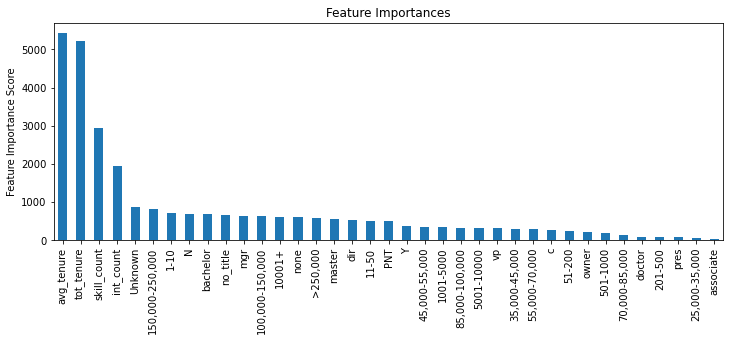

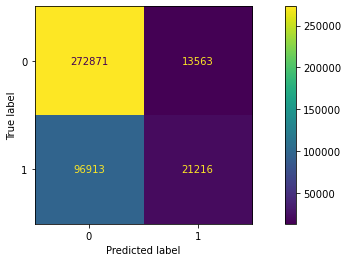

In [19]:
#Now we have optimal hyper-parameters, lower the learning rate and add more trees
xgb3 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.95,
 colsample_bytree=0.5,
 reg_alpha=1e-05,
 eval_metric='auc',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder=False)
modelfit(xgb3, train, predictors)

#Try with model that use aucpr as the loss function
def modelfit2(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='aucpr', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score : %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    cm = confusion_matrix(dtrain[target].values, dtrain_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=alg.classes_)
    disp.plot()
    plt.show()
    

xgb5 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=6,
 min_child_weight=5,
 gamma=0.4,
 subsample=0.95,
 colsample_bytree=0.55,
 reg_alpha=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit2(xgb5, train, predictors)


Model Report
Accuracy : 0.68
AUC Score : 0.707808


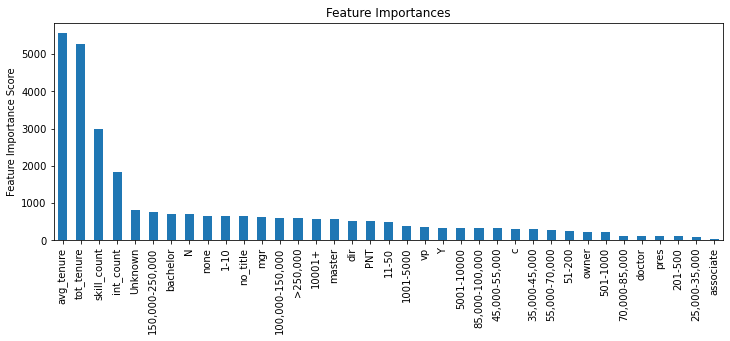

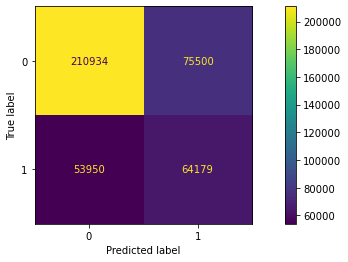

In [20]:
#Try higher scale_pos_weight, others holding constant
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.95,
 colsample_bytree=0.5,
 reg_alpha=1e-05,
 eval_metric='auc',
 nthread=4,
 scale_pos_weight=2,
 seed=27,
 use_label_encoder=False)

modelfit(xgb4, train, predictors)

In [21]:
#Apply the final model to the test dataset
y_pred = xgb3.predict(test[predictors])
y_prob = xgb3.predict_proba(test[predictors])[:,1]

print("Accuracy(Test) : %.4g" % metrics.accuracy_score(test[target].values, y_pred))
print("AUC Score (Test): %f" % metrics.roc_auc_score(test[target], y_prob))

Accuracy(Test) : 0.7253
AUC Score (Test): 0.699674


In [22]:
X = data[predictors]
y = data[target]

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [23]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

/home/chaoz_26/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[88509,  1182],
       [35771,   964]])

Text(0.5, 257.44, 'Predicted label')

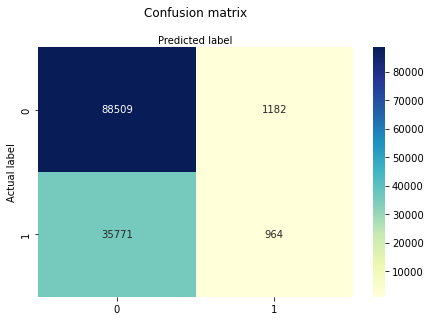

In [25]:
import seaborn as sns
%matplotlib inline


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [26]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7077104393083701
Precision: 0.44920782851817337
Recall: 0.026242003538859398


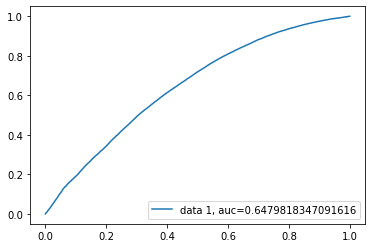

In [27]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [28]:
from sklearn.inspection import PartialDependenceDisplay

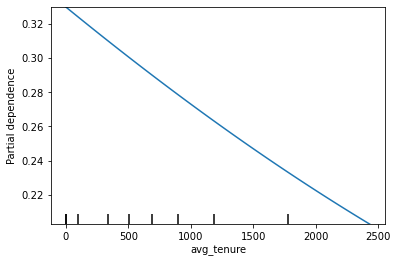

In [29]:
PartialDependenceDisplay.from_estimator(logreg, X_test, ['avg_tenure'])

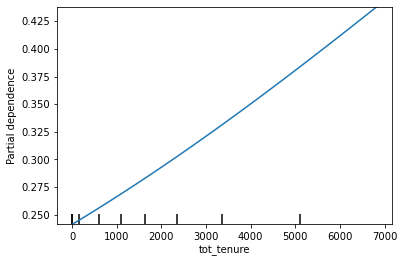

In [30]:
PartialDependenceDisplay.from_estimator(logreg, X_test, ['tot_tenure'])

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

In [32]:
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, plot_partial_dependence

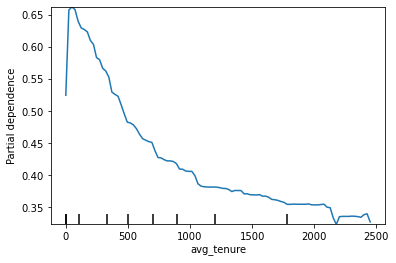

In [33]:
PartialDependenceDisplay.from_estimator(xgb4, train[predictors], ['avg_tenure'])

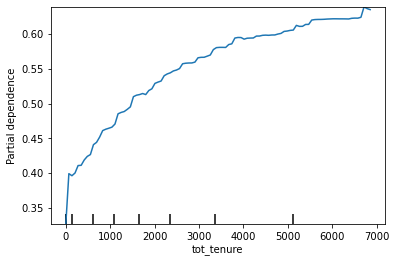

In [34]:
PartialDependenceDisplay.from_estimator(xgb4, train[predictors], ['tot_tenure'])

In [36]:
import shap

In [37]:
explainer = shap.TreeExplainer(xgb4)
shap_values = explainer.shap_values(train[predictors])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


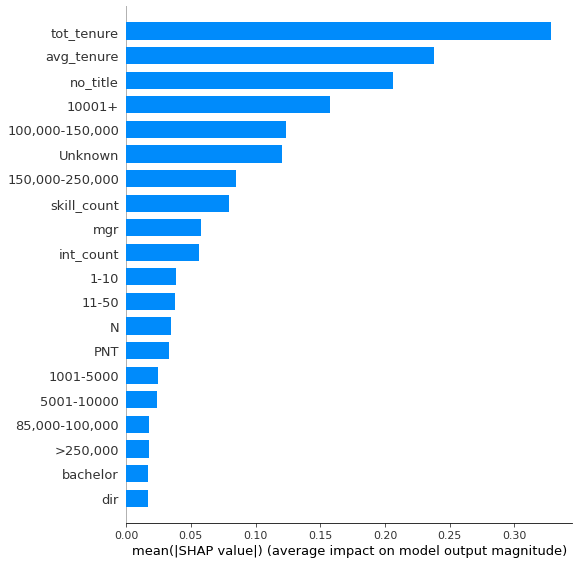

In [38]:
shap.summary_plot(shap_values, train[predictors], plot_type="bar")

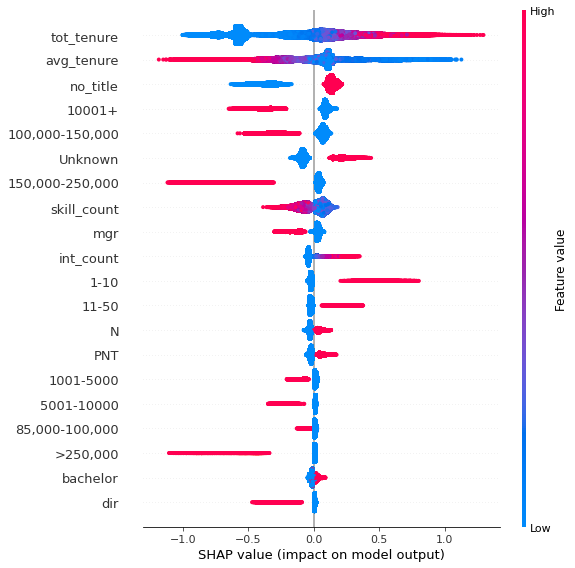

In [39]:
shap.summary_plot(shap_values, train[predictors])